In [2]:
from PIL import Image
import torch
import torch.nn.functional as F
from torchvision.transforms import transforms
import tensorflow as tf
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [2]:
batch_size = 100
img_height = 224
img_width = 224


In [3]:
training_dataset = tf.keras.utils.image_dataset_from_directory(directory="data/data/train",
                                                               labels="inferred",
                                                               color_mode="rgb",
                                                               validation_split=0.2,
                                                               subset="training",
                                                               seed=123,
                                                               image_size=(img_height, img_width),
                                                               batch_size=batch_size)

validation_dataset = tf.keras.utils.image_dataset_from_directory(directory="data/data/train",
                                                                labels="inferred",
                                                                color_mode="rgb",
                                                                validation_split=0.2,
                                                                subset="validation",
                                                                seed=123,
                                                                image_size=(img_height, img_width),
                                                                batch_size=batch_size)

test_dataset = tf.keras.utils.image_dataset_from_directory(directory="data/data/test",
                                                            labels="inferred",
                                                            color_mode="rgb",
                                                            image_size=(img_height, img_width),
                                                            batch_size = 100)




Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Found 5216 files belonging to 2 classes.
Using 1043 files for validation.
Found 624 files belonging to 2 classes.


In [4]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip('horizontal'),
                                         tf.keras.layers.RandomRotation(0.2)
                                         ])


In [5]:
rescale = tf.keras.layers.Rescaling(1./255)


In [6]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(img_height, img_width, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [7]:
model = tf.keras.Sequential([tf.keras.layers.Input(shape=(img_height, img_width, 3)),
                                data_augmentation,
                                rescale,
                                base_model,
                                tf.keras.layers.GlobalMaxPooling2D(),
                                tf.keras.layers.Dropout(0.2),
                                tf.keras.layers.Dense(1, activation="sigmoid")])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy','Precision','Recall','AUC'])

model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_max_pooling2d (Globa  (None, 1280)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                

In [3]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
augmented = tf.keras.layers.RandomFlip("horizontal")(inputs)
augmented = tf.keras.layers.RandomRotation(0.2)(augmented)

base_model = tf.keras.applications.MobileNetV2(input_tensor=augmented,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

pooling = tf.keras.layers.GlobalMaxPooling2D()(base_model.layers[-1].output)
dropout = tf.keras.layers.Dropout(0.2)(pooling)

dense_output = dropout
for i in range(3):
    dense_output =  tf.keras.layers.Dense(8, activation="relu")(dense_output)


final_output = tf.keras.layers.Dense(1, activation="sigmoid")(dense_output)
model = tf.keras.models.Model(inputs=inputs, outputs=final_output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 random_flip (RandomFlip)       (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 random_rotation (RandomRotatio  (None, 224, 224, 3)  0          ['random_flip[0][0]']            
 n)                                                                                               
                                                                                              

In [35]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy','Precision','Recall','AUC'])

In [36]:
n_epochs=5
history = model.fit(training_dataset,
                    epochs=n_epochs,
                    validation_data=validation_dataset)


Epoch 1/5
42/42 [==============================] - 162s 4s/step - loss: 0.6436 - accuracy: 0.7652 - precision: 0.8334 - recall: 0.8502 - auc: 0.7799 - val_loss: 0.4099 - val_accuracy: 0.7977 - val_precision: 0.8702 - val_recall: 0.8691 - val_auc: 0.8427
Epoch 2/5
42/42 [==============================] - 143s 3s/step - loss: 0.4618 - accuracy: 0.8402 - precision: 0.8863 - recall: 0.8976 - auc: 0.8846 - val_loss: 0.4568 - val_accuracy: 0.7737 - val_precision: 0.9348 - val_recall: 0.7617 - val_auc: 0.8720
Epoch 3/5
42/42 [==============================] - 142s 3s/step - loss: 0.4123 - accuracy: 0.8531 - precision: 0.8986 - recall: 0.9018 - auc: 0.9099 - val_loss: 0.7377 - val_accuracy: 0.6587 - val_precision: 0.9871 - val_recall: 0.5679 - val_auc: 0.8885
Epoch 4/5
42/42 [==============================] - 142s 3s/step - loss: 0.4028 - accuracy: 0.8572 - precision: 0.8973 - recall: 0.9096 - auc: 0.9128 - val_loss: 0.4419 - val_accuracy: 0.7872 - val_precision: 0.9523 - val_recall: 0.7642 - 

Text(0.5, 1.0, 'Training and validation accuracy')

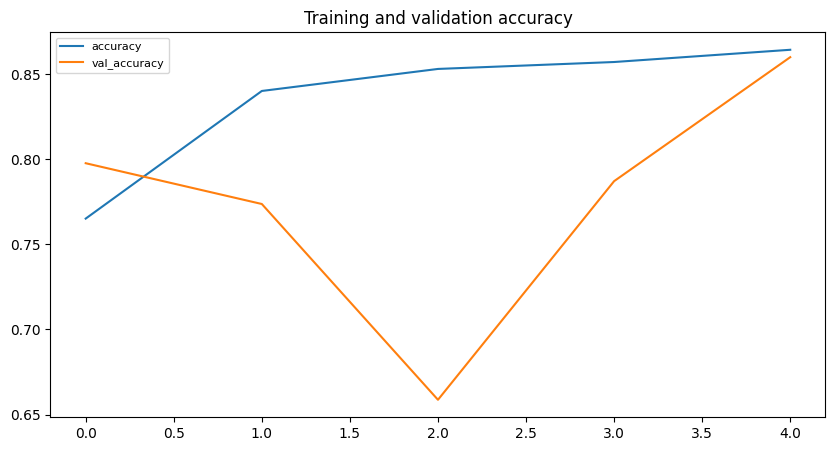

In [37]:
history_df = pd.DataFrame(history.history)
plt.figure(figsize=(10,5))
plt.plot(history_df["accuracy"], label="accuracy")
plt.plot(history_df["val_accuracy"], label='val_accuracy')
plt.legend(["accuracy", "val_accuracy"], loc="upper left", prop={"size": 8})
plot_name = f"Training and validation accuracy"
plt.title(plot_name)


Text(0.5, 1.0, 'Training and validation precision')

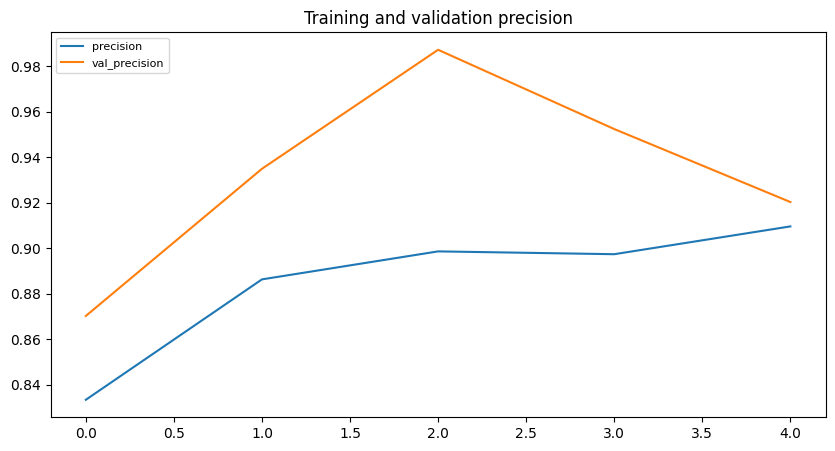

In [38]:
plt.figure(figsize=(10,5))
plt.plot(history_df["precision"], label="precision")
plt.plot(history_df["val_precision"], label='val_precision')
plt.legend(["precision", "val_precision"], loc="upper left", prop={"size": 8})
plot_name = f"Training and validation precision"
plt.title(plot_name)

Text(0.5, 1.0, 'Training and validation recall')

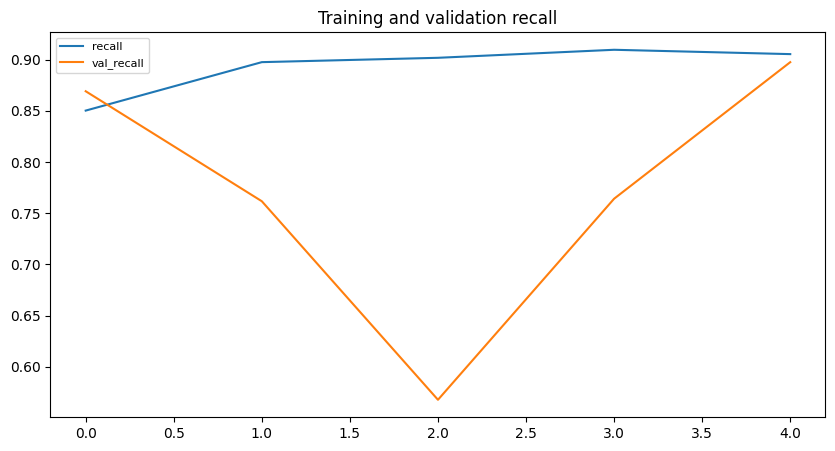

In [39]:
plt.figure(figsize=(10,5))
plt.plot(history_df["recall"], label="recall")
plt.plot(history_df["val_recall"], label='val_recall')
plt.legend(["recall", "val_recall"], loc="upper left", prop={"size": 8})
plot_name = f"Training and validation recall"
plt.title(plot_name)

In [40]:
history_df

,loss,accuracy,precision,recall,auc,val_loss,val_accuracy,val_precision,val_recall,val_auc
0,0.643598,0.765157,0.833387,0.850245,0.779868,0.409887,0.797699,0.870210,0.869136,0.842691
1,0.461837,0.840163,0.886276,0.897553,0.884646,0.456840,0.773730,0.934848,0.761728,0.872031
2,0.412291,0.853103,0.898570,0.901794,0.909934,0.737668,0.658677,0.987124,0.567901,0.888489
3,0.402805,0.857177,0.897329,0.909625,0.912757,0.441931,0.787152,0.952308,0.764198,0.905974
4,0.371393,0.864366,0.909538,0.905383,0.925297,0.319932,0.860019,0.920253,0.897531,0.914084


In [41]:
model.evaluate(test_dataset)

7/7 [==============================] - 19s 2s/step - loss: 0.6289 - accuracy: 0.7308 - precision: 0.7256 - recall: 0.9154 - auc: 0.7990


[0.6289494037628174,
 0.7307692170143127,
 0.7256097793579102,
 0.9153845906257629,
 0.7990028262138367]

In [95]:
img_arrays = []
predictions = np.array([])
labels =  np.array([])
for x, y in test_dataset:
  img_arrays.append(x)
  prediction_prob = model.predict(x).flatten()
  predictions = np.concatenate([predictions, tf.where(prediction_prob < 0.5, 0, 1)])
  labels = np.concatenate([labels, y.numpy()])

1/1 [==============================] - 1s 679ms/step


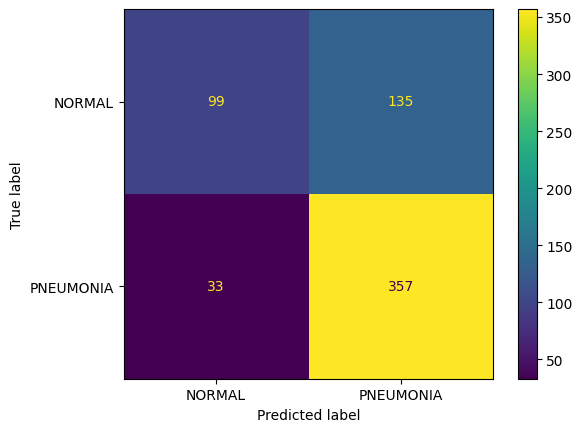

In [96]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(labels, predictions, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.class_names)
disp.plot()
plt.show()

In [161]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    model.layers[-1].activation = None
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape(persistent=True) as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [236]:
last_conv_layer_name = list(filter(lambda x: isinstance(x, tf.keras.layers.Conv2D), model.layers))[-1].name
last_conv_layer_name

'Conv_1'

In [83]:
model.inputs

[<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_10')>]

In [203]:
img_array = img_arrays[0][4]

prediction_prob = model.predict(np.expand_dims(img_array, axis=0))
prediction = np.where(prediction_prob < 0.5, 0, 1)
label = labels[0]
print(prediction_prob, prediction, label)

1/1 [==============================] - 0s 68ms/step
[[0.86848605]] [[1]] 1.0


In [209]:

img_tensor = img_array
img_tensor = np.expand_dims(img_tensor, axis=0)

heatmap = make_gradcam_heatmap(img_tensor, model, last_conv_layer_name)
heatmap = np.uint8(255 * heatmap)

img_tensor.shape


(1, 224, 224, 3)

In [205]:
# Create an image with RGB colorized heatmap
img_array_resized = tf.keras.preprocessing.image.array_to_img(img_array)
img_array_resized = img_array_resized.resize((500, 500))
img_array_resized = tf.keras.preprocessing.image.img_to_array(img_array_resized)


C:\Users\angus\AppData\Local\Temp\ipykernel_18188\3690956398.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


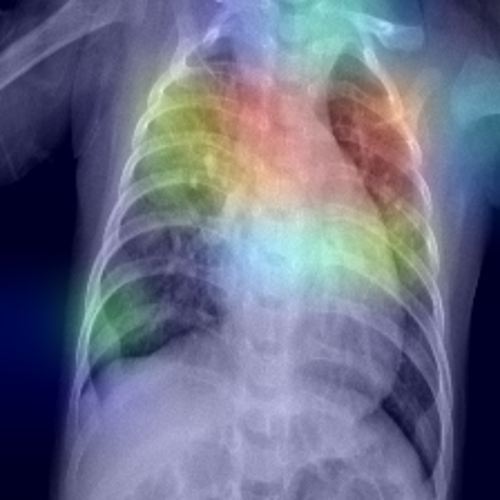

In [206]:
import matplotlib.cm as cm
# Use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# Use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# Create an image with RGB colorized heatmap
jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img_array_resized.shape[1], img_array_resized.shape[0]))
jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img_array_resized
superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
superimposed_img

In [226]:
img_array = np.expand_dims(img_arrays[0][0], axis=0)
img_array.shape

(1, 224, 224, 3)

In [227]:
np.squeeze(img_array).shape

(224, 224, 3)

1/1 [==============================] - 1s 545ms/step


C:\Users\angus\AppData\Local\Temp\ipykernel_18188\1973699948.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


1/1 [==============================] - 0s 69ms/step


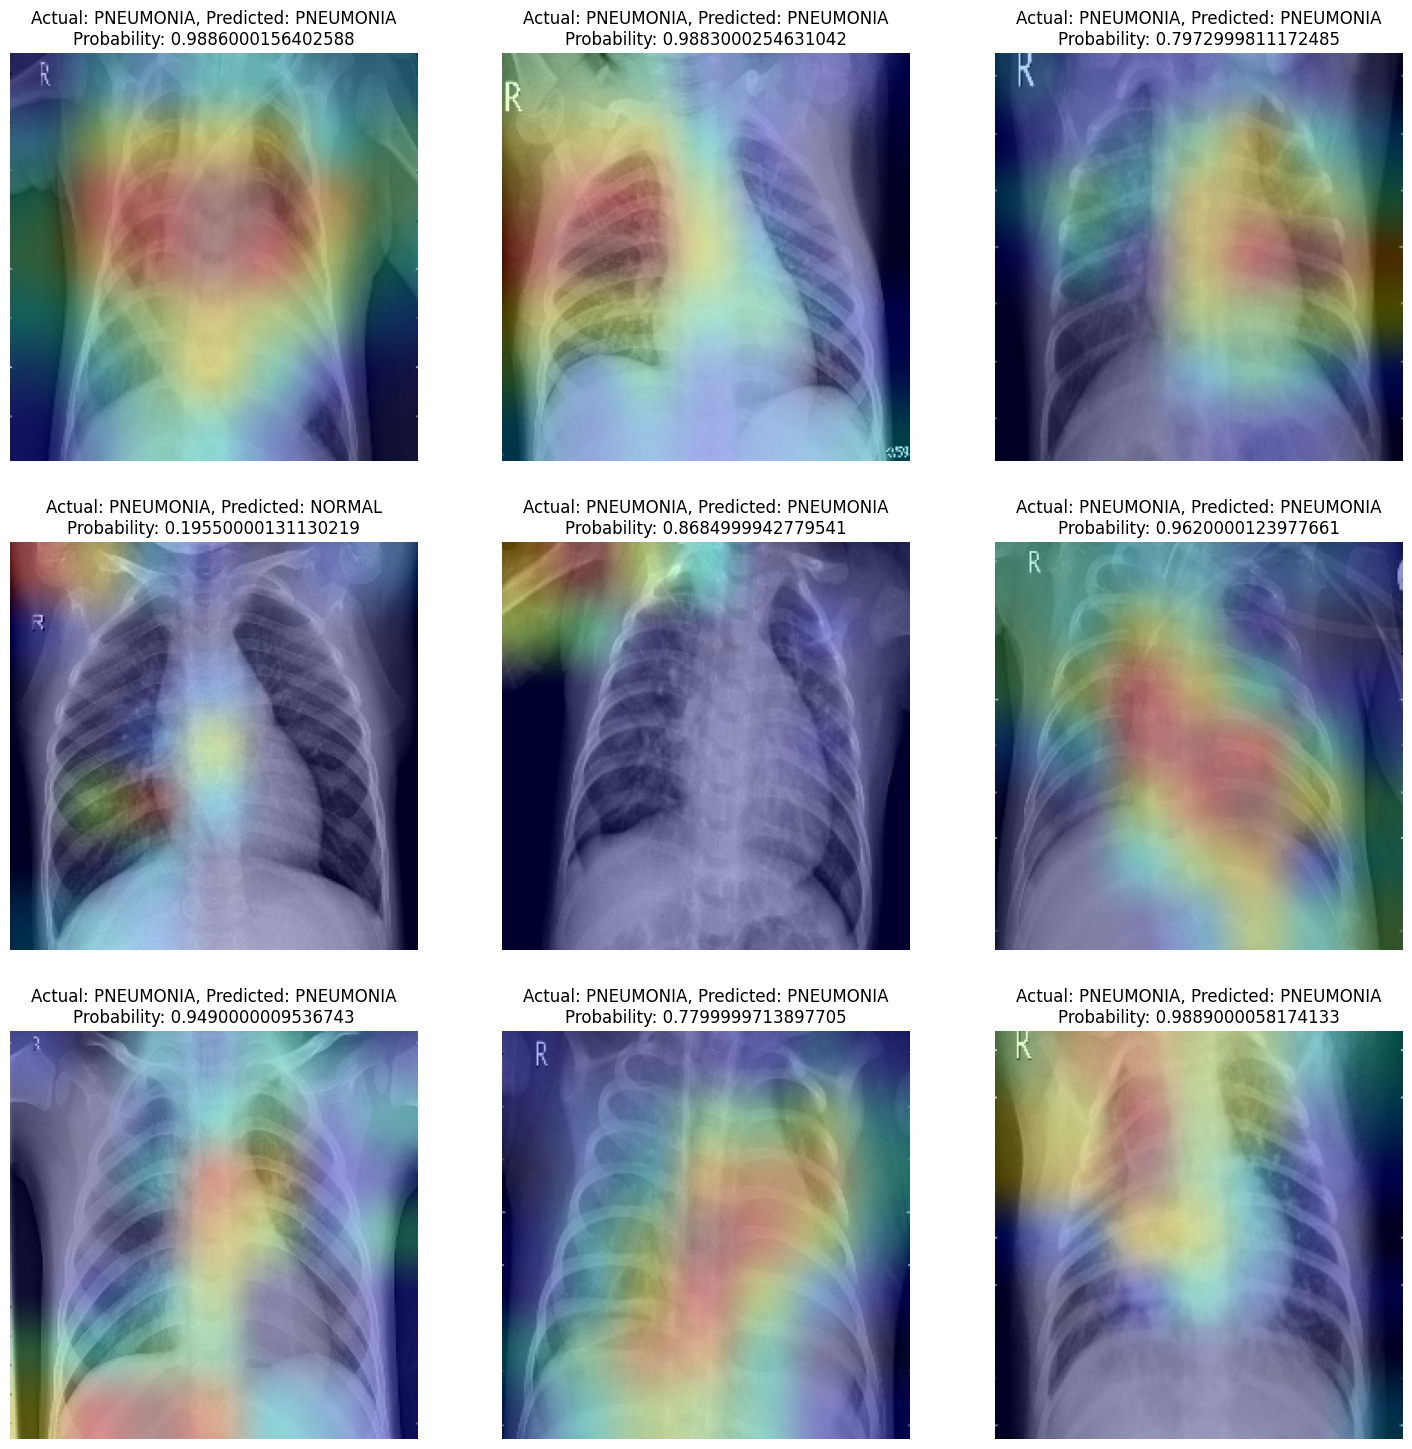

In [235]:
random_img_arrays = np.random.randint(99, size=9)

fig, axes = plt.subplots(3,3, figsize=(18,18))

for i in range(len(random_img_arrays)):

    img_array = np.expand_dims(img_arrays[0][i], axis=0)
    prediction_prob = model.predict(img_array)
    prediction = np.where(prediction_prob[0] < 0.5, "NORMAL", "PNEUMONIA")[0]
    label = "PNEUMONIA" if labels[i] == 1 else "NORMAL"

    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap("jet")
    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img_array.shape[1], img_array.shape[2]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + np.squeeze(img_array)
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    axes[i//3, i%3].imshow(superimposed_img)
    axes[i//3, i%3].set_title(f"Actual: {label}, Predicted: {prediction}\nProbability: {round(prediction_prob[0][0],4)}")
    axes[i//3, i%3].axis('off')

plt.show()

